In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from binarytree import tree,Node
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
import copy

In [18]:
df=pd.read_csv("train.csv")

In [19]:
X=df.drop(['left'],axis=1)
Y=df['left']

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
X_Original_train = copy.deepcopy(X_train)
X_Original_test = copy.deepcopy(X_test)
X_train = pd.concat([X_train,Y_train],axis=1)
eps = np.finfo(float).eps
numAttr=['last_evaluation','satisfaction_level','average_montly_hours','time_spend_company','number_project']
depthListtrain={}
depthListtest={}

In [21]:
def find_overall_entropy(X_train):
    output=X_train.keys()[-1]
    target_value_list=X_train[output].unique()
    entropy=0
    for value in target_value_list:
        frac = float(X_train[output].value_counts()[value])/(len(X_train[output])+eps)
        entropy+=-frac*np.log2(frac+eps)
    return abs(entropy)

In [22]:
def find_attr_entropy(X_train,attr):
    output=X_train.keys()[-1]
    target_value_list=X_train[output].unique()
    current_value_list=X_train[attr].unique()
    final_entropy=0
    den=1
    for cur_value in current_value_list:
        entropy=0
        for value in target_value_list:
            num = len(X_train[attr][X_train[attr] == cur_value][X_train[output] == value])
            den = len(X_train[attr][X_train[attr] == cur_value])
            frac=num/(den+eps)
            entropy+=-frac*np.log2(frac+eps)
        frac2=float(den)/len(X_train)
        final_entropy+=-frac2*entropy
    return abs(final_entropy)

In [23]:
def get_subdataframeNum1(X_train,node,value):
    return X_train[X_train[node] < value].reset_index(drop=True)

In [24]:
def get_subdataframeNum2(X_train,node,value):
    return X_train[X_train[node] >= value].reset_index(drop=True)

In [25]:
storemidpoint={}
storemidpoint.clear()
def split_calculation(X_train):
    entropy1=find_overall_entropy(X_train)
    for feature in numAttr:
        IGMax=0
        midmax=0
        uniqueVal = X_train[feature].unique()
        for mid in uniqueVal:
            
            subtable1=get_subdataframeNum1(X_train,feature,mid)
            subtable2=get_subdataframeNum2(X_train,feature,mid)
            firstentropy=0
            secondentropy=0
            if subtable1.empty:
                firstentropy=0
            else:
                frac1=float(len(subtable1))/len(X_train)
                firstentropy = frac1*find_overall_entropy(subtable1)
            if subtable2.empty:
                secondentropy=0
            else:
                frac2=float(len(subtable2))/len(X_train)
                secondentropy = frac2*find_overall_entropy(subtable2)

            entropy2=firstentropy+secondentropy
            ig=abs(entropy1)-abs(entropy2)
            if ig > IGMax:
                IGMax=ig
                midmax=mid
        _tuple=(IGMax,midmax)
        storemidpoint[feature]=_tuple
    return storemidpoint

In [26]:
def find_best_node(X_train):
    information_gain={}
    entropy_1=find_overall_entropy(X_train)
    for attr in X_train.keys()[:-1]:
        if attr not in numAttr:
            information_gain[attr]=((abs(entropy_1)-find_attr_entropy(X_train,attr)),0)
    return information_gain

In [27]:
def get_subdataframe(X_train,node,value):
    return X_train[X_train[node] == value].reset_index(drop=True)

In [28]:
class nodestruct:
    def __init__(self, value):
        self.value=value
        self.positive=0
        self.negative=0
        self.child=[]
        self.midpoint=0
        self.values=[]

In [29]:
def build_tree(X_train,depth):
    
    if len(X_train)==1:
        return None
    
    output=X_train.keys()[-1]
    outputValue,counts = np.unique(X_train[output],return_counts=True)                        
    
    
    if len(counts)<=1:
        root=nodestruct(outputValue[0])
        if outputValue[0]==0:
            root.negative = counts[0]
        else:
            root.positive = counts[0]
        return root
    
    else:
        if depth == 0:
            if counts[0]>counts[1]:
                root=nodestruct(outputValue[0])
            else:
                root=nodestruct(outputValue[1])
            return root
        numericsplit = split_calculation(X_train)
        categorysplit = find_best_node(X_train)
        numericsplit.update(categorysplit)
        wonAttr=""
        IGMAX=0
        Split_point=0
        
        for key,tuple_ in numericsplit.items():
            if IGMAX < tuple_[0]:
                IGMAX = tuple_[0]
                Split_point = tuple_[1]
                wonAttr = key
                
        categorysplit.clear()
        numericsplit.clear()
        if wonAttr=="":
            return
        root = nodestruct(wonAttr)
        root.midpoint = Split_point
        root.negative = counts[0]
        root.positive = counts[1]
        
        if wonAttr in numAttr:
            subtable0 = get_subdataframeNum1(X_train,wonAttr,Split_point)
            subtable1 = get_subdataframeNum2(X_train,wonAttr,Split_point)
            root.child.append(build_tree(subtable0,depth-1))
            root.child.append(build_tree(subtable1,depth-1))
            
        else:
            for j in X_train[wonAttr].unique():
                subtable0 = get_subdataframe(X_train,wonAttr,j)
                subtable0 = subtable0.drop([wonAttr],axis=1)
                root.values.append(j)
                root.child.append(build_tree(subtable0,depth-1))
    
        return root

In [30]:
def testing(X_test,root):
    
    if len(root.child)==0:
        y_pred.append(root.value)
        return
    i=root.value
    flag=0
    if i in numAttr:
        if X_test[i]<root.midpoint and root.child[0]!=None:
            flag=1
            testing(X_test,root.child[0])
        elif root.child[1]!=None:
            flag=1
            testing(X_test,root.child[1])
        if flag==0:
            if root.positive>root.negative:
                y_pred.append(1)
            else:
                y_pred.append(0)
            return
    else:
        k=0
        for j in root.values:
            if X_test[i]==j:
                if root.child[k]!=None:
                    flag=1
                    testing(X_test,root.child[k])
                    break
                else:
                    if root.positive>root.negative:
                        y_pred.append(1)
                    else:
                        y_pred.append(0)
                    return
            k=k+1
        if flag==0:
            if root.positive>root.negative:
                y_pred.append(1)
            else:
                y_pred.append(0)
            return

In [31]:
depth=2
while depth<21:
                
    rootNode=build_tree(X_train,depth)

    y_pred=[]

    X_train1=copy.deepcopy(X_Original_train)
    X_test1=copy.deepcopy(X_Original_test)
    
    for index,row in X_test1.iterrows():
        testing(row,rootNode)

    depthListtest[depth] = 1-accuracy_score(Y_test, y_pred)
    print("Testing Error---->",depthListtest[depth])
    del y_pred[:]

    
    for index,row in X_train1.iterrows():
        testing(row,rootNode)
        
    depthListtrain[depth] = 1-accuracy_score(Y_train, y_pred)
    print("Training Error---->",depthListtrain[depth])
    del y_pred[:]
    depth=depth+2

('Testing Error---->', 0.18905693950177938)
('Training Error---->', 0.17530589543937714)
('Testing Error---->', 0.03202846975088969)
('Training Error---->', 0.03403781979977749)
('Testing Error---->', 0.022686832740213547)
('Training Error---->', 0.022914349276974444)
('Testing Error---->', 0.020462633451957313)
('Training Error---->', 0.014794215795328136)
('Testing Error---->', 0.017793594306049876)
('Training Error---->', 0.012013348164627402)
('Testing Error---->', 0.020017793594306)
('Training Error---->', 0.0101223581757508)
('Testing Error---->', 0.020907473309608515)
('Training Error---->', 0.008787541713014435)
('Testing Error---->', 0.022241992882562234)
('Training Error---->', 0.00856507230255843)
('Testing Error---->', 0.02313167259786475)
('Training Error---->', 0.008342602892102313)
('Testing Error---->', 0.02313167259786475)
('Training Error---->', 0.008342602892102313)


Text(0.5,1,'depth vs error')

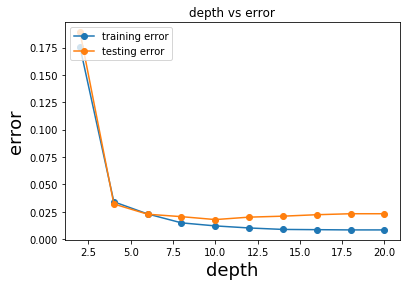

In [32]:
fig, ax = plt.subplots()
x_axis = [i for i in xrange(2,21,2)]
ax.plot(x_axis, depthListtrain.values(), label="training error",marker='o')
ax.plot(x_axis, depthListtest.values(), label="testing error",marker='o')
ax.legend(loc=2) # upper left corner
ax.set_xlabel("depth", fontsize=18)
ax.set_ylabel("error", fontsize=18)
ax.set_title('depth vs error')

In [33]:
df1 = pd.read_csv("train.csv")
X1 = df1.drop(['left'],axis=1)
Y1 = df1['left']
X1 = pd.concat([X1,pd.get_dummies(X1['sales'], prefix='sales')],axis=1)
X1 = pd.concat([X1,pd.get_dummies(X1['salary'], prefix='salary')],axis=1)
X1.drop(['sales','salary'],axis=1, inplace=True)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1,Y1,test_size = 0.2)
modelTrain = DecisionTreeClassifier()
modelTrain.fit(X_train1,Y_train1)
Y_predict=modelTrain.predict(X_test1)
print confusion_matrix(Y_test1,Y_predict)
print classification_report(Y_test1,Y_predict)
print accuracy_score(Y_test1, Y_predict)

[[1702   24]
 [  27  495]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1726
           1       0.95      0.95      0.95       522

   micro avg       0.98      0.98      0.98      2248
   macro avg       0.97      0.97      0.97      2248
weighted avg       0.98      0.98      0.98      2248

0.9773131672597865
